Original Model Accuracy: 0.5900
Epsilon: 0.00 - Adversarial Accuracy: 0.5900
Epsilon: 0.01 - Adversarial Accuracy: 0.5100
Epsilon: 0.10 - Adversarial Accuracy: 0.1400
Epsilon: 0.15 - Adversarial Accuracy: 0.0500
Epsilon: 0.20 - Adversarial Accuracy: 0.0100
Epsilon: 0.25 - Adversarial Accuracy: 0.0100


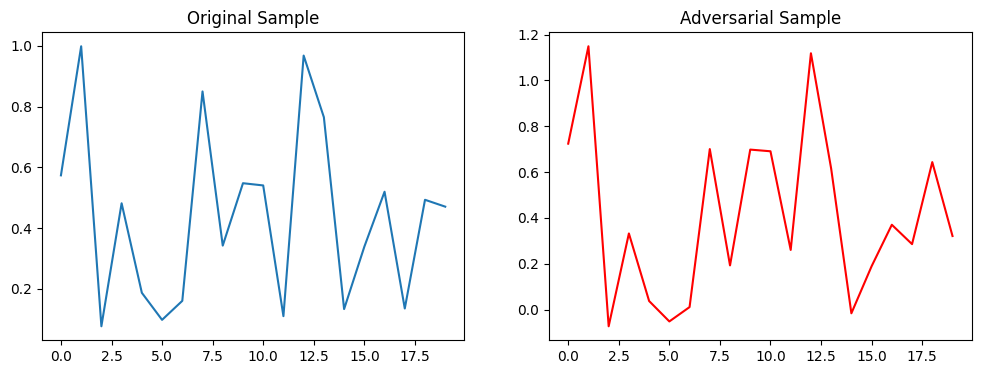

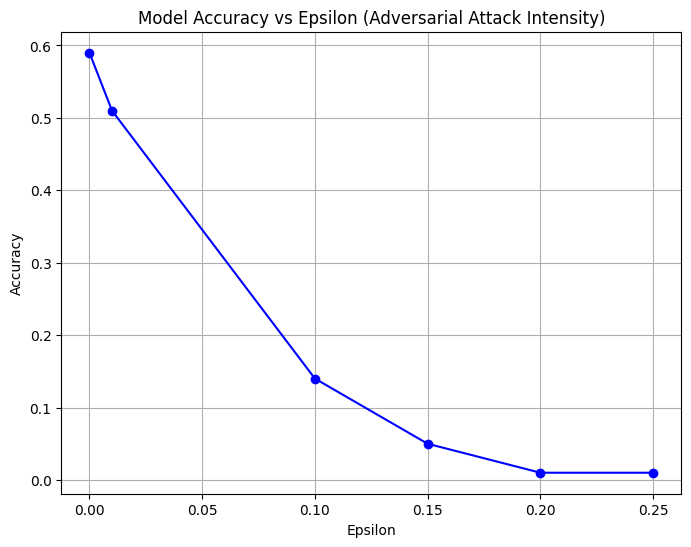

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Sample synthetic dataset for binary classification (benign or malicious)
X_train = np.random.rand(1000, 20)  # 1000 samples, 20 features
y_train = np.random.randint(0, 2, 1000)  # Binary labels (0: benign, 1: malicious)

# Simple neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(20,)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

# Define the FGSM adversarial attack
def fgsm_attack(model, X, y, epsilon=0.1):
    X = tf.convert_to_tensor(X)  # Convert input to tensor
    y = tf.convert_to_tensor(y)  # Convert labels to tensor
    y = tf.reshape(y, (-1, 1))  # Reshape y to match the output shape

    with tf.GradientTape() as tape:
        tape.watch(X)
        prediction = model(X)
        loss = tf.keras.losses.binary_crossentropy(y, prediction)

    # Get the gradients of the loss w.r.t the input
    gradient = tape.gradient(loss, X)

    # Get the sign of the gradients to create the adversarial perturbation
    signed_grad = tf.sign(gradient)

    # Create adversarial example by adding perturbation to the original input
    adversarial_example = X + epsilon * signed_grad

    return adversarial_example

# Evaluate model performance on original and adversarial examples
def evaluate_adversarial_effect(model, X_test, y_test, epsilons):
    accuracy_results = []
    for epsilon in epsilons:
        X_adv = fgsm_attack(model, X_test, y_test, epsilon)
        adv_loss, adv_acc = model.evaluate(X_adv, y_test, verbose=0)
        accuracy_results.append((epsilon, adv_acc))
        print(f"Epsilon: {epsilon:.2f} - Adversarial Accuracy: {adv_acc:.4f}")
    return accuracy_results

# Plot original vs adversarial examples
def plot_comparison(X_original, X_adversarial, sample_idx=0):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(X_original[sample_idx], label='Original Sample')
    plt.title('Original Sample')

    plt.subplot(1, 2, 2)
    plt.plot(X_adversarial[sample_idx], label='Adversarial Sample', color='r')
    plt.title('Adversarial Sample')

    plt.show()

# Test data (subsample of training data for simplicity)
X_test = X_train[:100]
y_test = y_train[:100]

# Evaluate the model on original data
original_loss, original_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Original Model Accuracy: {original_acc:.4f}")

# Range of epsilon values for FGSM attacks
epsilons = [0.0, 0.01, 0.1, 0.15, 0.2, 0.25]

# Evaluate model performance with different epsilon values
accuracy_results = evaluate_adversarial_effect(model, X_test, y_test, epsilons)

# Generate adversarial examples with a specific epsilon
epsilon_to_visualize = 0.15
X_adv_example = fgsm_attack(model, X_test, y_test, epsilon=epsilon_to_visualize)

# Plot comparison of original vs adversarial examples
plot_comparison(X_test, X_adv_example)

# Plot accuracy results
eps, accuracies = zip(*accuracy_results)
plt.figure(figsize=(8, 6))
plt.plot(eps, accuracies, marker='o', linestyle='-', color='b')
plt.title('Model Accuracy vs Epsilon (Adversarial Attack Intensity)')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()
